In [94]:
import plac
import random
import pandas as pd 
from pathlib import Path
import spacy
from spacy import displacy
from spacy.util import minibatch, compounding
import networkx as nx
import matplotlib.pyplot as plt

%matplotlib inline  


In [2]:
# Extract Relationships section

In [3]:
def extract_event_loc_relations(doc):
    # merge entities and noun chunks into one token
    spans = list(doc.ents) + list(doc.noun_chunks)
    for span in spans:
        span.merge()

    relations = []
    for location in filter(lambda w: w.ent_type_ == 'LOC', doc):
        if location.dep_ in ('attr', 'dobj'):
            subject = [w for w in location.head.lefts if w.dep_ == 'nsubj']
            if subject:
                subject = subject[0]
                relations.append((subject, location))
        elif location.dep_ == 'pobj' and location.head.dep_ == 'prep':
            relations.append((location.head.head, location))
    return relations

In [4]:
def extract_person_loc_relations(doc):
    # merge entities and noun chunks into one token
    spans = list(doc.ents) + list(doc.noun_chunks)
    for span in spans:
        span.merge()

    relations_person = []
    for person in filter(lambda w: w.ent_type_ == 'PERSON', doc):
        if person.dep_ in ('attr', 'dobj'):
            subject = [w for w in person.head.lefts if w.dep_ == 'nsubj']
            if subject:
                subject = subject[0]
                relations_person.append((subject, person))
        elif person.dep_ == 'pobj' and person.head.dep_ == 'prep':
            person.append((person.head.head, person))
    return relations_person

In [5]:
# new entity label
LABEL = 'RANK'

# training data
TRAIN_DATA = [
    ('Mandro training centre', {
        'entities': [(0, 22, 'LOC')]
    }),
    ('My name is Marcus BRODY. I am 15 years old', {
        'entities': [(11, 24, 'PERSON')]
    }),
    ('visited the camp one time', {
        'entities': [(0, 25, 'EVENT')]
    }),
    ('I went to a rally in Goma', {
        'entities': [(21, 25, 'LOC')]
    }),
    ('In late 2002', {
        'entities': [(8, 12, 'DATE')]
    }),
    ('there was a lot of fighting in Goma', {
        'entities': [(31, 35, 'LOC')]
    }), 
    ("I remember one of the commanders who spoke was Chief KOBONO", {
        'entities': [(47, 52, 'RANK')]
    }),
    ("The President, Ule MATOBO GOBO", {
        'entities': [(0, 13, 'RANK')]
    }),
     ('there was a lot of fighting in Goma', {
        'entities': [(19, 35, 'EVENT')]
    })
    
]

In [6]:
#add new entity
nlp = spacy.load('en')
if 'ner' not in nlp.pipe_names:
    ner = nlp.create_pipe('ner')
    nlp.add_pipe(ner)
# otherwise, get it, so we can add labels to it
else:
    ner = nlp.get_pipe('ner')
    ner.add_label(LABEL)   # add new entity label to entity recognizer

optimizer = nlp.begin_training()
for i in range(20):
    random.shuffle(TRAIN_DATA)
    for text, annotations in TRAIN_DATA:
        nlp.update([text], [annotations], sgd=optimizer)
nlp.to_disk('model')
        
# test the trained model
for text, _ in TRAIN_DATA:
        doc = nlp(text)
        if text != "":
            print('Entities', [(ent.text, ent.label_) for ent in doc.ents])
        #print('Tokens', [(t.text, t.ent_type_, t.ent_iob) for t in doc])
        
#df = pd.DataFrame.from_dict(ent.text, ent.label_)
#df.drop_duplicates(keep=False, inplace=True)
#df.head()
#df.to_csv('WITNESS_OUT_NODES.csv',header=['label','node_type'],index_label='Id')

Entities [('visited the camp one time', 'EVENT')]
Entities [('2002', 'DATE')]
Entities [('Chief', 'RANK')]
Entities [('Marcus BRODY.', 'PERSON')]
Entities []
Entities [('Mandro training centre', 'LOC')]
Entities [('Goma', 'LOC')]
Entities []
Entities [('The President', 'RANK')]


In [8]:
#import text file
witness_file = open('../witness_text_clean.txt','r')
#witness_file = open('witness2.txt','r')
text_witness = ""
text_witness = witness_file.read() 
if text_witness != "":
   text = text_witness

#load spacy model
nlp = spacy.load('model')
#nlp = spacy.load('en_core_web_lg')
#doc = nlp(text_witness)

#create relationships
doc = nlp(text_witness)
relations = extract_event_loc_relations(doc)
for r1, r2 in relations:
    print('RELATIONSHIP :'+'{:<10}\t{}\t{}'.format(r1.text,r2.ent_type_,r2.text))
    
#if relations !="":
    relation_df = pd.DataFrame.from_dict(relations)
    relation_df.columns =['event', 'location']
    relation_df['event'] = [token.text for token in relation_df['event'].values]
    relation_df['location'] = [token.text for token in relation_df['location'].values]
    relation_df['relation'] = 'took_place_at'
    relation_df.to_csv('WITNESS_STAT_OUTPUT_NODES.csv',index_label='Id')
#else:
#    print('NO RELATIONS FOUND')

        
# Print the results

displacy.render(doc, style='ent',jupyter=True)

RELATIONSHIP :fighting  	LOC	Goma
RELATIONSHIP :a rally   	LOC	Goma
RELATIONSHIP :the  training centre	LOC	Mandro


In [9]:
events = list(set(relation_df['event'].values))
locations = list(set(relation_df['location'].values))
types = ['event'] * len(events) + ['location'] * len(locations)

entity_df = pd.DataFrame({'entity': events + locations, 'type': types})


In [10]:
entity_df

,entity,type
0,fighting,event
1,the training centre,event
2,a rally,event
3,Goma,location
4,Mandro,location


In [11]:
relation_df

,event,location,relation
0,fighting,Goma,took_place_at
1,a rally,Goma,took_place_at
2,the training centre,Mandro,took_place_at


In [12]:
event_ids =  [entity_df.index[entity_df['entity'] == entity_name].tolist()[0] for entity_name in relation_df['event']]
relation_df['event_id'] = event_ids
location_ids =  [entity_df.index[entity_df['entity'] == entity_name].tolist()[0] for entity_name in relation_df['location']]
relation_df['location_id'] = location_ids

In [13]:
G = nx.from_pandas_edgelist(df=relation_df, source='event_id', target='location_id', edge_attr='relation')
entity_ids = entity_df.index.values
G.add_nodes_from(entity_ids)
nx.set_node_attributes(G, {i:{'Name': row['entity']} for i,row in entity_df.iterrows()})

In [14]:
labels = {i:row['entity'] for i,row in entity_df.iterrows()}
edge_labels = {i:' took place at ' for i,row in entity_df.iterrows()}

In [15]:
labels

{0: 'fighting',
 1: 'the  training centre',
 2: 'a rally',
 3: 'Goma',
 4: 'Mandro'}

In [16]:
edge_labels

{0: ' took place at ',
 1: ' took place at ',
 2: ' took place at ',
 3: ' took place at ',
 4: ' took place at '}

In [17]:
entity_df['entity'].values

array(['fighting', 'the  training centre', 'a rally', 'Goma', 'Mandro'],
      dtype=object)

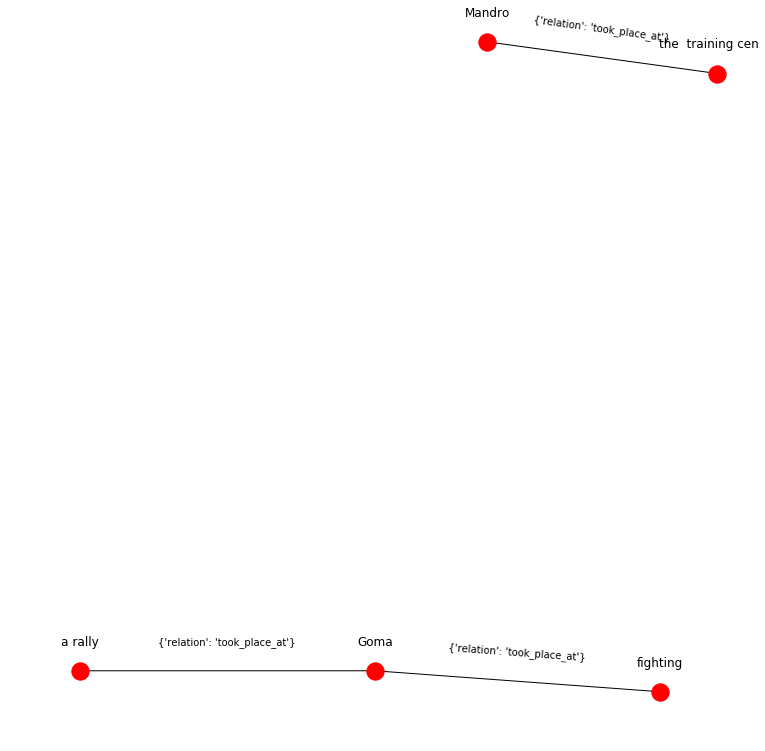

In [93]:
plt.figure(figsize=[10, 10])
pos = nx.spring_layout(G, scale=2)
#bb = nx.edge_betweenness_centrality(G, normalized=False)
#nx.set_edge_attributes(G, ' took place at ', bb)
nx.draw(G, pos, font_size=16, with_labels=False)
for p in pos:
    pos[p][1] += 0.15

#nx.draw_networkx_edges(G, pos, style='solid', alpha=0.2,labels=' took place at ')
nx.draw_networkx_labels(G, pos, labels=labels)
nx.draw_networkx_edge_labels(G, pos, labels = edge_labels)

plt.savefig("Graph.png", format="PNG")
